#Applying LSTM to predict stock price of VNIndex

In [24]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-03-23 15:41:46.952939: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 15:41:46.978877: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 15:41:46.979819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 15:41:48.401622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Upload data


In [10]:
df = pd.read_csv("data/markets_historical_vnindex_ind.csv", parse_dates = ["Date"]).set_index(["Date"]).filter(["Price"]).sort_values(by=["Date"])
df

,Price
Date,
2002-12-31,183.33
2003-01-02,183.41
2003-01-03,182.39
2003-01-06,181.76
2003-01-07,180.63
...,...
2022-12-26,985.21
2022-12-27,"1,004.57"
2022-12-28,"1,015.66"


In [11]:
df["Price"] = df["Price"].str.replace(",", "").astype(float)

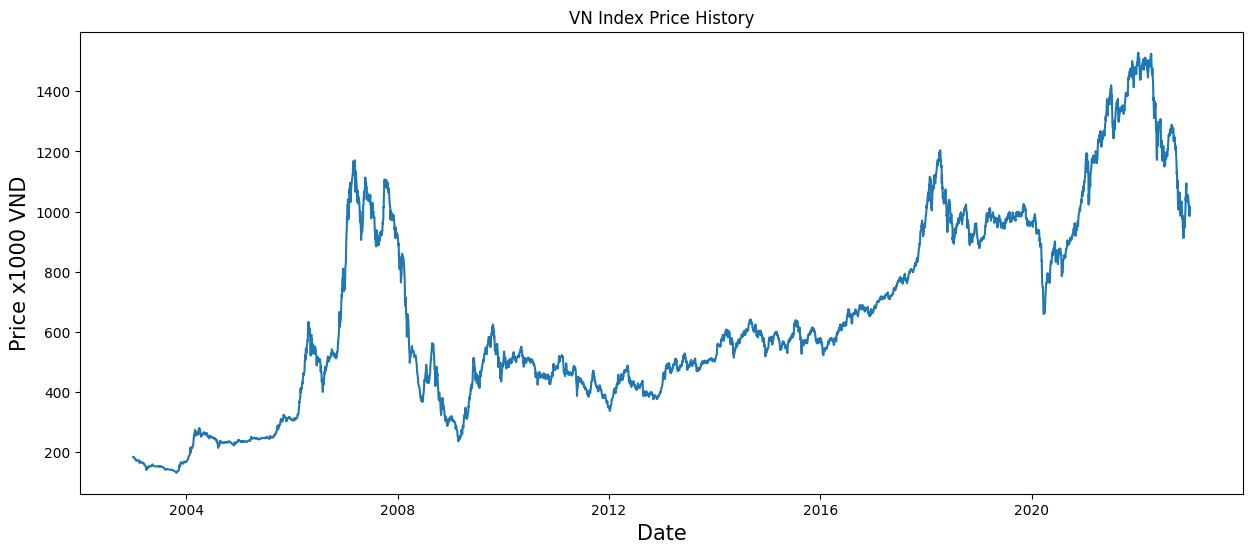

In [12]:
plt.figure(figsize=(15,6))
plt.title('VN Index Price History')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.show()

## Preprocessing

In [13]:
# Normalize data using MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(df.values)
scaled_data

array([[0.03751243],
       [0.03756967],
       [0.03683988],
       ...,
       [0.63302496],
       [0.62846738],
       [0.62689333]])

In [15]:
# Save the scaler
import joblib
joblib.dump(scaler, "model/scaler.sc")

['model/scaler.sc']

In [16]:
# Split data
train_data, test_data = np.split(scaled_data, [int(len(scaled_data)*0.9)])
test_data = np.append(train_data[len(train_data)-60:,],test_data)

In [17]:
# Each query in the training set will contain 60 time-steps and 1 output, which is also the last time step.
X_train = []
y_train = []

for i in range (60,len(train_data)):
  X_train.append(train_data[i-60:i,])
  y_train.append(train_data[i,])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4431, 60, 1)

In [18]:
len(test_data)

560

## Model


In [25]:
# Define the model
model = keras.Sequential()

model.add(layers.LSTM(128, return_sequences = True, input_shape=(X_train.shape[1],1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences = False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32))
model.add(layers.Dense(1))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
139/139 [==============================] - 9s 46ms/step - loss: 0.0052
Epoch 2/10
139/139 [==============================] - 6s 47ms/step - loss: 0.0013
Epoch 3/10
139/139 [==============================] - 6s 46ms/step - loss: 9.9611e-04
Epoch 4/10
139/139 [==============================] - 7s 47ms/step - loss: 7.9720e-04
Epoch 5/10
139/139 [==============================] - 7s 47ms/step - loss: 6.6884e-04
Epoch 6/10
139/139 [==============================] - 6s 45ms/step - loss: 6.6582e-04
Epoch 7/10
139/139 [==============================] - 6s 45ms/step - loss: 5.3313e-04
Epoch 8/10
139/139 [==============================] - 6s 45ms/step - loss: 5.5066e-04
Epoch 9/10
139/139 [==============================] - 6s 45ms/step - loss: 5.1204e-04
Epoch 10/10
139/139 [==============================] - 6s 45ms/step - loss: 4.9622e-04


In [30]:
model.save("model/stock_prediction.h5")


# Prediction & Evaluation

In [31]:
# Reshape test data
X_test = []
y_test = []

for i in range (60,len(test_data)):
  X_test.append(test_data[i-60:i,])
  y_test.append(test_data[i,])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(500, 60, 1)

In [32]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)
prediction[:5]

16/16 [==============================] - 1s 18ms/step


array([[1076.214 ],
       [1079.7893],
       [1084.3137],
       [1090.1993],
       [1097.5591]], dtype=float32)

In [38]:
print(len(prediction)) 

500


In [34]:
# Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, prediction, squared = False)
rmse

1264.2192204636472

In [35]:
# Create a dataframe of test data for visualization
test_df = df[len(train_data):]
test_df['Predict'] = prediction
test_df

/tmp/ipykernel_149842/1307817642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predict'] = prediction


,Price,Predict
Date,,
2020-12-31,1103.87,1076.213989
2021-01-04,1120.47,1079.789307
2021-01-05,1132.55,1084.313721
2021-01-06,1143.21,1090.199341
2021-01-07,1156.49,1097.559082
...,...,...
2022-12-26,985.21,1024.543335
2022-12-27,1004.57,1019.142395
2022-12-28,1015.66,1013.253723


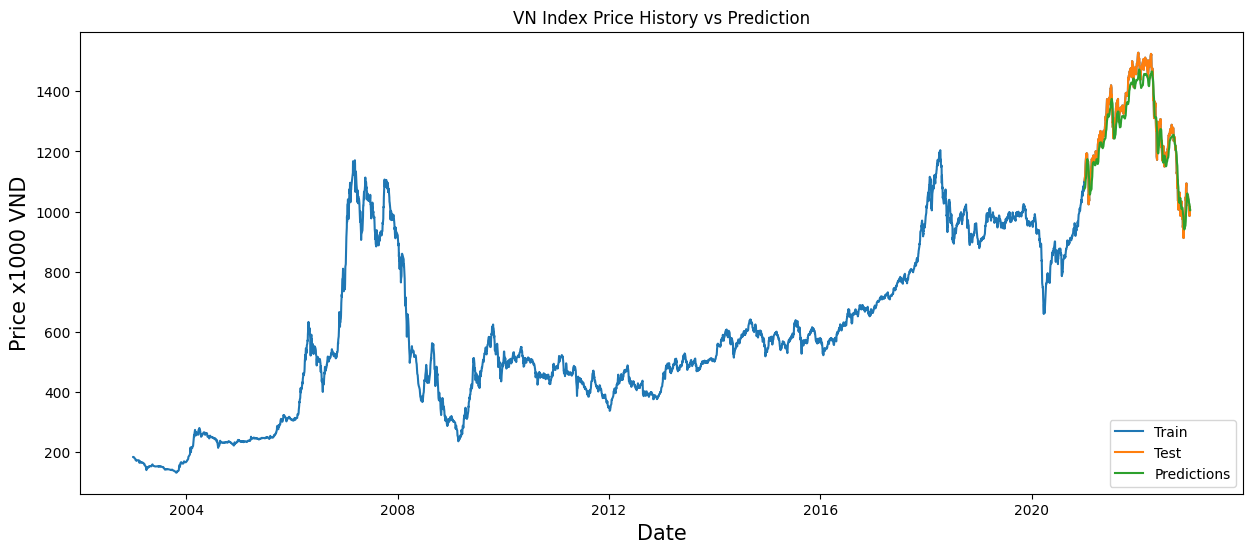

In [36]:
plt.figure(figsize=(15,6))
plt.title('VN Index Price History vs Prediction')
plt.plot(df['Price'])
plt.plot(test_df[['Price', 'Predict']])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

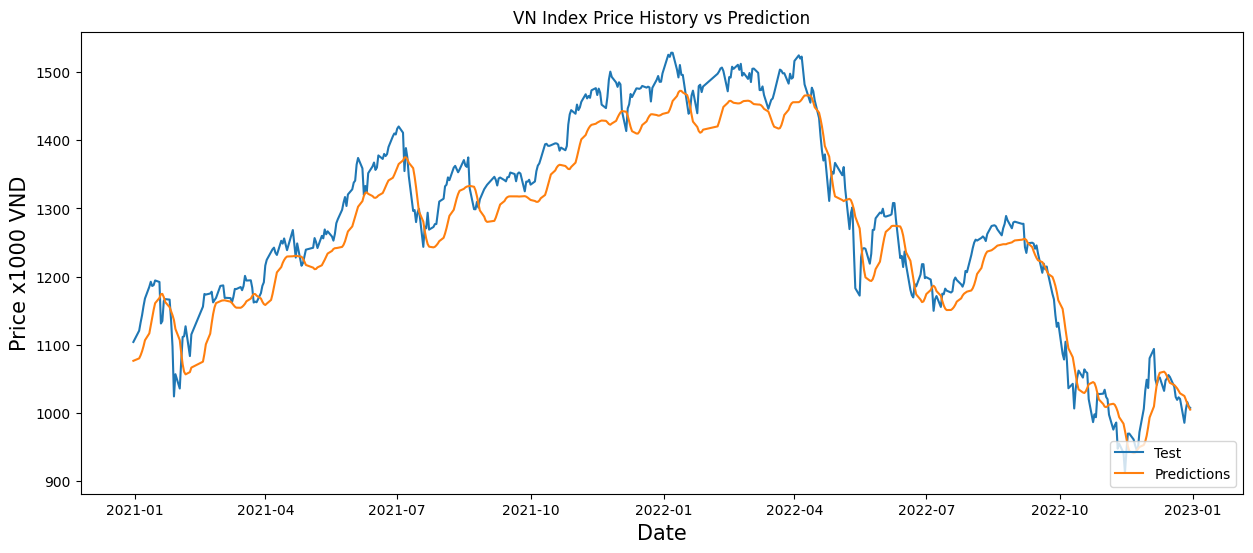

In [37]:
# compare between test and prediction
plt.figure(figsize=(15,6))
plt.title('VN Index Price History vs Prediction')
plt.plot(test_df[['Price', 'Predict']])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()